<a href="https://colab.research.google.com/github/esfandiaryfard/machine-learning/blob/main/HomeWork1_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
import numpy as np
import random
drive = drive.mount('/content/drive')
!unzip drive/MyDrive/Medical.zip -d Medical

In [3]:
dataset = torchvision.datasets.ImageFolder('Medical/')
num_train = len(dataset)
train_idx = list(range(num_train))

random.seed(1)
random.shuffle(train_idx)

test_frac =0.1

num_test = int(num_train * test_frac) 
num_train = num_train - num_test

test_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]


print(f"{num_train} samples used as train set")
print(f"{num_test}  samples used as test set")

53059 samples used as train set
5895  samples used as test set


In [4]:
random.seed(1)
random.shuffle(train_idx)

val_frac =0.1

num_val = int(num_train * val_frac) 
num_train = num_train - num_val

val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]


print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as test set")

47754 samples used as train set
5305  samples used as test set


In [5]:
from torchvision.transforms.transforms import Normalize
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

dataset = torchvision.datasets.ImageFolder('Medical/', transform=data_transform)

test_set = Subset(dataset, test_idx)
val_set = Subset(dataset, val_idx)
train_set = Subset(dataset, train_idx)

train_loader = DataLoader(
    train_set, batch_size=64, num_workers=0, shuffle=True
    )
val_loader   = DataLoader(
    val_set,   batch_size=64, num_workers=0, shuffle=False
    )
test_loader  = DataLoader(
    test_set,  batch_size=64, num_workers=0, shuffle=False
    )

In [6]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
  def forward(self, x):
    x = self.conv_layer(x)
    return x
  
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [8]:
test_x, _ = train_set[0] 
test_x.size()

torch.Size([3, 32, 32])

In [9]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 32, 32])

In [10]:
output = model(test_x)
output.shape

torch.Size([1, 256, 5, 5])

In [11]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

6400


In [27]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
      # Layer 1
      nn.Conv2d(
          in_channels=3, 
          out_channels=64, 
          kernel_size=3, 
          padding=1, 
          stride=1
          ),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(
          in_channels=64, 
          out_channels=128, 
          kernel_size=3, 
          padding=1, 
          stride=1
          ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(
          in_channels=128, 
          out_channels=256, 
          kernel_size=3, 
          padding=1, 
          stride=1
          ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(
          in_channels=256, 
          out_channels=512, 
          kernel_size=3, 
          padding=1, 
          stride=1
          ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(
          in_channels=512, 
          out_channels=512, 
          kernel_size=3, 
          padding=1, 
          stride=1
          ),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(
          in_channels=512, 
          out_channels=6, 
          kernel_size=2, 
          padding=0, 
          stride=1
          )
    )
    
  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.conv_layer(x)
    return output.view(b, -1)

In [28]:
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 6])

In [29]:
torch.cuda.is_available()

False

In [30]:
dev = torch.device('cpu')
print(dev)

cpu


In [31]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [32]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in tqdm(loaders[split],desc=split):
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [33]:
# Define dictionary of loaders
loaders = {"train": train_loader,   
           "val": val_loader,
           "test": test_loader}

train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1: TrL=0.6340, TrA=0.7773, VL=0.3152, VA=0.9037, TeL=0.3210, TeA=0.8981,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2: TrL=0.0393, TrA=0.9879, VL=0.0194, VA=0.9955, TeL=0.0175, TeA=0.9965,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3: TrL=0.0197, TrA=0.9947, VL=0.0161, VA=0.9951, TeL=0.0132, TeA=0.9960,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4: TrL=0.0127, TrA=0.9965, VL=0.0085, VA=0.9977, TeL=0.0085, TeA=0.9978,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5: TrL=0.0112, TrA=0.9969, VL=0.0092, VA=0.9976, TeL=0.0109, TeA=0.9968,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6: TrL=0.0085, TrA=0.9975, VL=0.0098, VA=0.9983, TeL=0.0125, TeA=0.9971,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7: TrL=0.0072, TrA=0.9978, VL=0.0066, VA=0.9981, TeL=0.0049, TeA=0.9985,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8: TrL=0.0062, TrA=0.9982, VL=0.0055, VA=0.9985, TeL=0.0072, TeA=0.9980,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9: TrL=0.0056, TrA=0.9982, VL=0.0052, VA=0.9985, TeL=0.0067, TeA=0.9983,


train:   0%|          | 0/747 [00:00<?, ?it/s]

val:   0%|          | 0/83 [00:00<?, ?it/s]

test:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10: TrL=0.0045, TrA=0.9986, VL=0.0054, VA=0.9985, TeL=0.0044, TeA=0.9985,


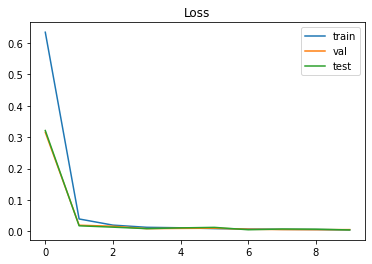

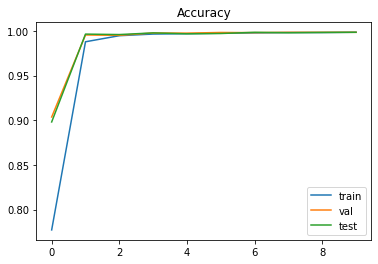

In [34]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)